In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import imageio
from collections import defaultdict
import pprint
import json

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
import seaborn as sns

from metrics_tools import compute_f_score

In [3]:
import dataframe_image as dfi

In [4]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

## Set working directories

In [5]:
use_training_data = False
training_name = "raw_sparks_lovasz_physio"
ignore_frames = 6 # first and last 6 frames not used for computing metrics

In [6]:
# raw data directories
raw_data_dir = os.path.join("..","data","raw_data_and_processing")
raw_movies_dir = os.path.join(raw_data_dir,"original_movies")
raw_masks_dir = os.path.join(raw_data_dir,"original_masks")

# poster directory
#poster_dir = "C:/Users/dotti/OneDrive - Universitaet Bern/EWGCCE meeting 22/figures"
poster_dir = "C:/Users/dotti/OneDrive - Universitaet Bern/midterm/figures"

In [7]:
if not use_training_data:
    metrics_dir = os.path.join("trainings_validation", training_name)
else:
    metrics_dir = os.path.join("trainings_validation", "train_samples", training_name)
    

In [8]:
per_pixel_res_dir = os.path.join(metrics_dir, 'per_pixel_results')

spark_peaks_res_dir = os.path.join(metrics_dir, 'spark_peaks_results')

## Ca2+ events signal plots 

In [9]:
font = {#'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

In [10]:
matplotlib.rc('font', **font)

### Spark

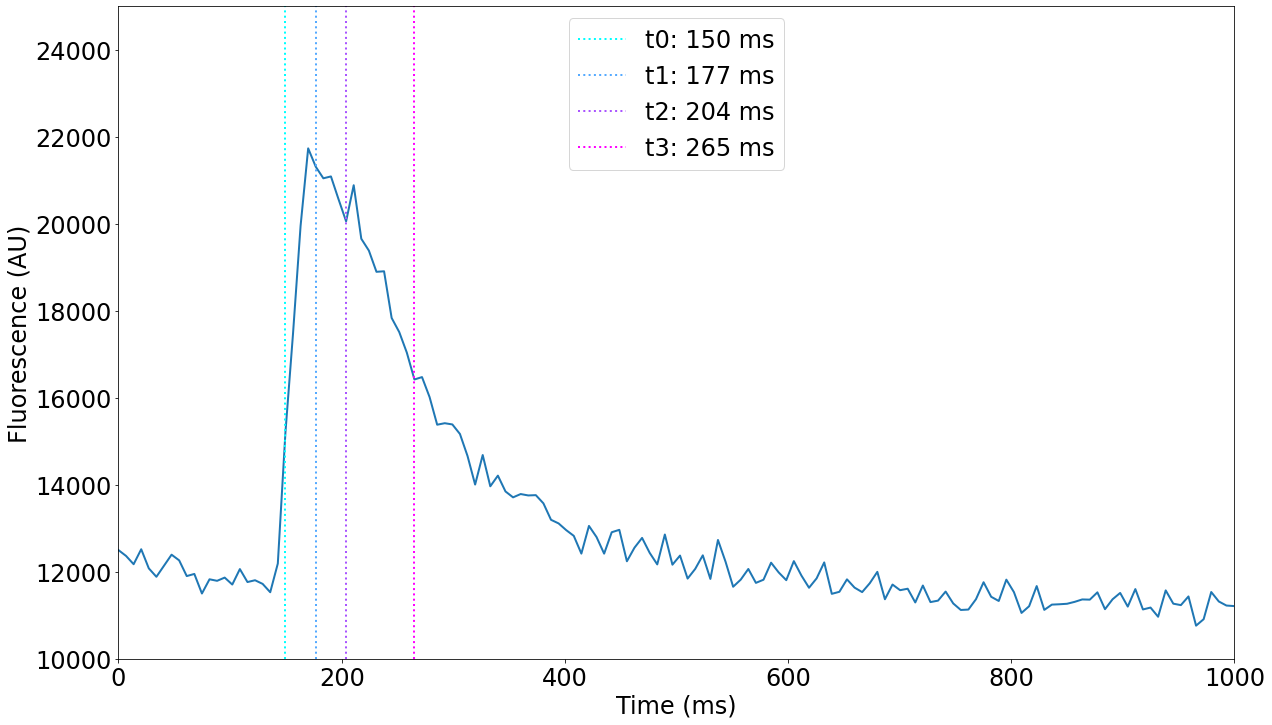

In [97]:
spark_sample_data_dir = os.path.join(poster_dir, "spark_example")
spark_sample_data_file = os.path.join(spark_sample_data_dir, "signal_plot.csv")

spark_event_df = pd.read_csv(spark_sample_data_file)

time_steps_idx = [22,26,30,39]
time_steps = [spark_event_df['Time_(ms)'][t] for t in time_steps_idx]

fig, ax = plt.subplots()
spark_event_df.plot(figsize=(20,12),
                    ax=ax,
                    x="Time_(ms)",
                    y="Fluorescence_(AU)", 
                    xlabel="Time (ms)", 
                    ylabel="Fluorescence (AU)",
                    xlim=(0,1000),
                    ylim=(10000,25000),
                    legend=False,
                    lw=2,
                    label='_nolegend_',
                    #fontsize=16
                   )

color = cm.cool(np.linspace(0, 1, len(time_steps)))
for i, t in enumerate(time_steps):
    ax.axvline(t, color=color[i], linestyle='dotted', lw=2, label=f"t{i}: {t:.0f} ms")
    
plt.legend(loc=9)
plt.savefig(os.path.join(spark_sample_data_dir, "spark_example_plot.png"), bbox_inches='tight')

### Puff

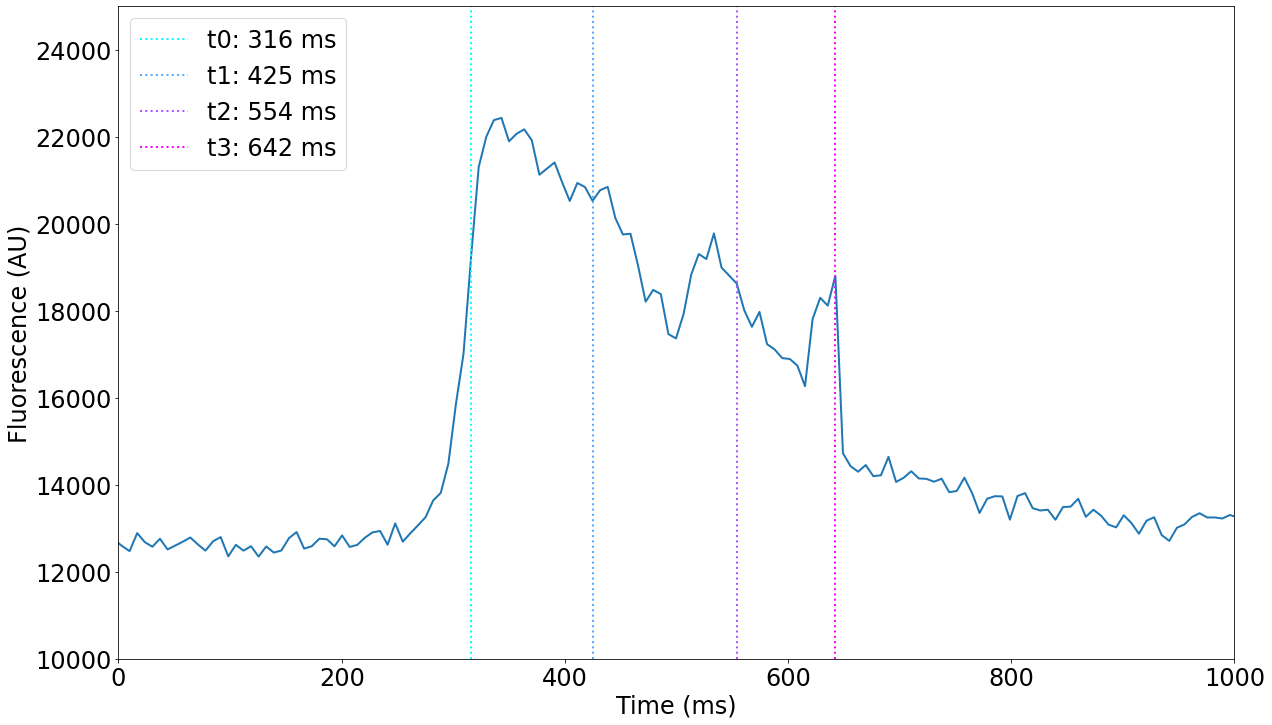

In [98]:
puff_sample_data_dir = os.path.join(poster_dir, "puff_example")
puff_sample_data_file = os.path.join(puff_sample_data_dir, "signal_plot.csv")

puff_event_df = pd.read_csv(puff_sample_data_file)

offset = 500

time_steps_idx = [120,136,155,168]
time_steps = [puff_event_df['Time_(ms)'][t]-offset for t in time_steps_idx]

puff_event_df['Time_(ms)'] = puff_event_df['Time_(ms)'].subtract(offset)

fig, ax = plt.subplots()
puff_event_df.plot(figsize=(20,12),
                    ax=ax,
                    x="Time_(ms)",
                    y="Fluorescence_(AU)", 
                    xlabel="Time (ms)", 
                    ylabel="Fluorescence (AU)",
                    xlim=(0,1000),
                    ylim=(10000,25000),
                    legend=False,
                    lw=2,
                    label='_nolegend_',
                    #fontsize=16
                   )

color = cm.cool(np.linspace(0, 1, len(time_steps)))
for i, t in enumerate(time_steps):
    ax.axvline(t, color=color[i], linestyle='dotted', lw=2, label=f"t{i}: {t:.0f} ms")
    
plt.legend(loc=2)
plt.savefig(os.path.join(puff_sample_data_dir, "puff_example_plot.png"), bbox_inches='tight')

### Wave

In [11]:
wave_sample_data_dir = os.path.join(poster_dir, "wave_example")
wave_sample_data_file = os.path.join(wave_sample_data_dir, "signal_plot.csv")

wave_event_df = pd.read_csv(wave_sample_data_file)

In [12]:
wave_event_df

,Slice,Mean
0,1,6079.017
1,2,5834.432
2,3,5830.985
3,4,5898.072
4,5,6046.333
...,...,...
106,107,7058.847
107,108,7744.812
108,109,6968.638
109,110,7086.951


In [11]:
offset = 2300

time_steps_idx = [355,383,418,435]
time_steps = [wave_event_df['Time_(ms)'][t]-offset for t in time_steps_idx]

wave_event_df['Time_(ms)'] = wave_event_df['Time_(ms)'].subtract(offset)

fig, ax = plt.subplots()
wave_event_df.plot(figsize=(20,12),
                    ax=ax,
                    x="Time_(ms)",
                    y="Fluorescence_(AU)", 
                    xlabel="Time (ms)", 
                    ylabel="Fluorescence (AU)",
                    xlim=(0,1000),
                    ylim=(5000,20000),
                    legend=False,
                    lw=2,
                    label='_nolegend_',
                    #fontsize=16
                   )

color = cm.cool(np.linspace(0, 1, len(time_steps)))
for i, t in enumerate(time_steps):
    ax.axvline(t, color=color[i], linestyle='dotted', lw=2, label=f"t{i}: {t:.0f} ms")
    
plt.legend(loc=2)
plt.savefig(os.path.join(wave_sample_data_dir, "wave_example_plot.png"), bbox_inches='tight')

KeyError: 'Time_(ms)'

## Puffs and waves IoUs + MCC

In [9]:
ys_classes = ['puffs','waves']
metrics = ['iou', 'mcc']

In [10]:
per_pixel_rows = []
for event_class in ys_classes:
    # load saved dict and get rows for dataframe
    dict_filename = os.path.join(per_pixel_res_dir, event_class+"_results.json" )
    with open(dict_filename, 'r') as f:
        res = json.load(f) # movie_name x t x min_r x exclusion_r x video_id x metrics
        
        for movie_name, t_res in res.items():
            for t, min_r_res in t_res.items():
                for min_r, exclusion_r_res in min_r_res.items():
                    for exclusion_r, val in exclusion_r_res.items():
                        res[movie_name][t][min_r][exclusion_r]['iou'] = val['tp']/(val['tp']+val['fn']+val['fp']) if (val['tp']+val['fn']+val['fp']) != 0 else 1.0
                        res[movie_name][t][min_r][exclusion_r]['dice'] = val['tp']/(2*val['tp']+val['fn']+val['fp']) if (val['tp']+val['fn']+val['fp']) != 0 else 1.0
                        res[movie_name][t][min_r][exclusion_r]['prec'] = val['tp']/(val['tp']+val['fp']) if (val['tp']+val['fp']) != 0 else 1.0
                        res[movie_name][t][min_r][exclusion_r]['rec'] = val['tp']/(val['tp']+val['fn']) if (val['tp']+val['fn']) != 0 else 1.0
                        res[movie_name][t][min_r][exclusion_r]['accuracy'] = (val['tp']+val['tn'])/(val['tp']+val['tn']+val['fp']+val['fn'])
                        res[movie_name][t][min_r][exclusion_r]['mcc'] = (val['tp']*val['tn']-val['fp']*val['fn'])/np.sqrt(float((val['tp']+val['fp'])*(val['tp']+val['fn'])*(val['tn']+val['fp'])*(val['tn']+val['fn']))) if (val['tp']+val['fp'])*(val['tp']+val['fn'])*(val['tn']+val['fp'])*(val['tn']+val['fn']) != 0 else 0.0
                        
                        for metric_name, metric_val in val.items():
                            per_pixel_rows.append([event_class, movie_name, t, min_r, exclusion_r, metric_name, metric_val])

In [11]:
per_pixel_df = pd.DataFrame(per_pixel_rows, columns =['Event type', 'Movie name', 'Detection t', 'Min r', 'Exclusion r', 'Metric', 'Val'])

In [12]:
per_pixel_df[(per_pixel_df['Metric'].isin(metrics)) & (per_pixel_df['Movie name'] == '05')]

,Event type,Movie name,Detection t,Min r,Exclusion r,Metric,Val
4,puffs,05,0.0,0,0,iou,0.006076
9,puffs,05,0.0,0,0,mcc,0.012132
14,puffs,05,0.0,2,0,iou,0.006076
19,puffs,05,0.0,2,0,mcc,0.012132
24,puffs,05,0.0,4,0,iou,0.006076
...,...,...,...,...,...,...,...
9659,waves,05,argmax,2,0,mcc,0.000000
9664,waves,05,argmax,4,0,iou,1.000000
9669,waves,05,argmax,4,0,mcc,0.000000
9674,waves,05,argmax,6,0,iou,1.000000


In [13]:
metric_name = 'mcc'
min_r = '0'
event_type = 'waves'

thresholds = per_pixel_df['Detection t'].unique()
movie_names = per_pixel_df['Movie name'].unique()

In [14]:
thresholds, movie_names

(array(['0.0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4',
        '0.45', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85',
        '0.9', '0.95', '1.0', 'argmax'], dtype=object),
 array(['05', '10', '15', '20', '25', '32', '34', '40', '45', 'average'],
       dtype=object))

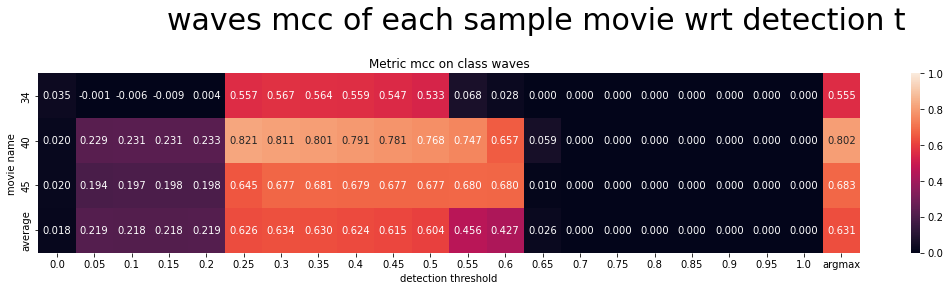

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 4), squeeze = False)
plt.subplots_adjust(hspace=0.1, wspace=0.01, top=0.85)
fig.suptitle(f"{event_type} {metric_name} of each sample movie wrt detection t", fontsize=30, y=1)

i=0
j=0

# loop through metrics, thresholds and axes
df_values = per_pixel_df[(per_pixel_df['Event type']==event_type) 
                         & (per_pixel_df['Min r']==min_r) 
                         & (per_pixel_df['Metric']==metric_name)
                         & (per_pixel_df['Movie name'].isin(wave_movies_names+['average']))
                        ]
# create pivot table, detection thresholds will be rows, min radius will be columns
piv = pd.pivot_table(df_values, values="Val",index=["Movie name"], columns=["Detection t"])

#plot pivot table as heatmap using seaborn
axs[i,j].set_title(f"Metric {metric_name} on class {event_type}")
sns.heatmap(piv, annot=True, fmt='.3f', vmin=0, vmax=1, ax=axs[i,j])#, square=True)
axs[i,j].set_ylabel("movie name")
axs[i,j].set_xlabel("detection threshold")

plt.setp(axs[i,j].yaxis.get_majorticklabels(), rotation=90) # rotate y labels
plt.tight_layout()

#ax.get_legend().remove()

plt.savefig(os.path.join(per_pixel_res_dir,"MEETING_"+event_type+"_"+metric_name+"_heatmap.png"))

### Get movies that contain puffs or waves
number of annotated pixels = tp + fn

In [15]:
min_r = '0'
detection_t = '0.5'
exclusion_r = '0'
metrics_annot = ['tp','fn']

In [16]:
# movies that contain puffs
event_type = 'puffs'


df_values = per_pixel_df[(per_pixel_df['Event type']==event_type) 
                         & (per_pixel_df['Min r']==min_r) 
                         & (per_pixel_df['Detection t']==detection_t)
                         & (per_pixel_df['Exclusion r']==exclusion_r)
                         & (per_pixel_df['Metric'].isin(metrics_annot))
                        ]

# get list of movies that contains puffs
n_tp = df_values[(df_values['Metric']==metrics_annot[0])]['Val'].values
n_fn = df_values[(df_values['Metric']==metrics_annot[1])]['Val'].values

n_annot = n_tp+n_fn
puff_movies = n_annot > 0
puff_movies_names = [movie_name for movie_name, present in zip(movie_names, puff_movies) if present and movie_name != 'average']
puff_movies_names

['05', '10', '15', '20', '25', '32', '34', '40']

In [17]:
# movies that contain waves
event_type = 'waves'


df_values = per_pixel_df[(per_pixel_df['Event type']==event_type) 
                         & (per_pixel_df['Min r']==min_r) 
                         & (per_pixel_df['Detection t']==detection_t)
                         & (per_pixel_df['Exclusion r']==exclusion_r)
                         & (per_pixel_df['Metric'].isin(metrics_annot))
                        ]

# get list of movies that contains waves
n_tp = df_values[(df_values['Metric']==metrics_annot[0])]['Val'].values
n_fn = df_values[(df_values['Metric']==metrics_annot[1])]['Val'].values

n_annot = n_tp+n_fn
wave_movies = n_annot > 0
wave_movies_names = [movie_name for movie_name, present in zip(movie_names, wave_movies) if present and movie_name != 'average']
wave_movies_names

['34', '40', '45']

### Compute average IoU and MCC for movies that contain given event

In [18]:
exclusion_r = '0'

In [19]:
def compute_mcc(tp,tn,fp,fn):
    if (tp!=0) and (tn==0) and (fp==0) and (fn==0):
        mcc = 1
    elif (tn!=0) and (tp==0) and (fp==0) and (fn==0):
        mcc = 1
    elif (fp!=0) and (tp==0) and (tn==0) and (fn==0):
        mcc = -1
    elif (fn!=0) and (tp==0) and (tn==0) and (fp==0):
        mcc = -1
    elif (tp==0) and (fn==0) and (fp!=0) and (tn!=0):
        mcc = 0
    elif (fp==0) and (tn==0) and (tp!=0) and (fn!=0):
        mcc = 0
    elif (tp==0) and (fp==0) and (fn!=0) and (tn!=0):
        mcc = 0
    elif (fn==0) and (tn==0) and (tp!=0) and (fp!=0):
        mcc = 0
    else:
        mcc = (tp*tn-fp*fn)/np.sqrt(float((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    
    return mcc
                                    

In [20]:
per_movie_per_pixel_rows = []
for event_class in ys_classes:
    # load saved dict and get rows for dataframe
    dict_filename = os.path.join(per_pixel_res_dir, event_class+"_results.json" )
    with open(dict_filename, 'r') as f:
        original_res = json.load(f) # movie_name x t x min_r x exclusion_r x video_id x metrics
        for movie_name, t_res in original_res.items():
            if (event_class == 'puffs') and (movie_name in puff_movies_names):
                for t, min_r_res in t_res.items():
                    for min_r, exclusion_r_res in min_r_res.items():
                        val = exclusion_r_res[exclusion_r]
                        per_movie_per_pixel_rows.append([event_class, movie_name, t, min_r, 'iou', val['tp']/(val['tp']+val['fn']+val['fp']) if (val['tp']+val['fn']+val['fp']) != 0 else 1.0])
                        per_movie_per_pixel_rows.append([event_class, movie_name, t, min_r, 'mcc', compute_mcc(val['tp'],val['tn'],val['fp'],val['fn'])])
                        
            if (event_class == 'waves') and (movie_name in wave_movies_names):
                for t, min_r_res in t_res.items():
                    for min_r, exclusion_r_res in min_r_res.items():
                        val = exclusion_r_res[exclusion_r]
                        per_movie_per_pixel_rows.append([event_class, movie_name, t, min_r, 'iou', val['tp']/(val['tp']+val['fn']+val['fp']) if (val['tp']+val['fn']+val['fp']) != 0 else 1.0])
                        per_movie_per_pixel_rows.append([event_class, movie_name, t, min_r, 'mcc', compute_mcc(val['tp'],val['tn'],val['fp'],val['fn'])])

per_movie_per_pixel_df = pd.DataFrame(per_movie_per_pixel_rows, columns =['Event type', 'Movie name', 'Detection t', 'Min r', 'Metric', 'Val'])

In [21]:
event_class = 'puffs'
metric = 'iou'
min_radius = per_pixel_df['Min r'].unique()
thresholds = per_pixel_df['Detection t'].unique()

In [22]:
average_per_pixel_rows = []

for event_class in ys_classes:
    for metric in metrics:
        df_values = per_movie_per_pixel_df[(per_movie_per_pixel_df['Event type']==event_class)
                                         & (per_movie_per_pixel_df['Metric']==metric)]

        for min_r in min_radius:
            for t in thresholds:
                avg = df_values[(df_values['Min r']==min_r)
                                & (df_values['Detection t']==t)
                               ]['Val'].mean()
                average_per_pixel_rows.append([event_class, t, min_r, metric, avg])

average_per_pixel_df = pd.DataFrame(average_per_pixel_rows, columns =['Event type', 'Detection t', 'Min r', 'Metric', 'Val'])

In [24]:
average_per_pixel_df.to_csv(os.path.join(per_pixel_res_dir,"POSTER_average_metrics_puffs_waves.csv"))

### Plot results

Average iou value for class puffs using argmax preds is 0.18001831902365972
Average iou value for class waves using argmax preds is 0.50840949166196
Average mcc value for class puffs using argmax preds is 0.3148731748551313
Average mcc value for class waves using argmax preds is 0.6800461799092142


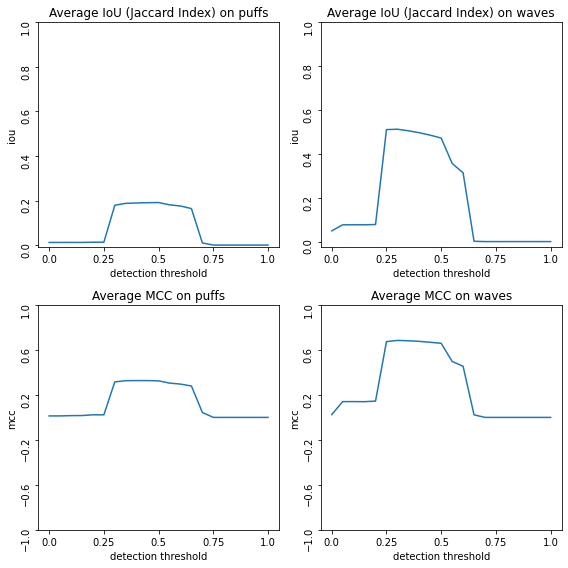

In [22]:
# create plot for all classes and all metrics
fig, axs = plt.subplots(nrows=len(metrics), ncols=len(ys_classes), figsize=(8, 8), squeeze = False)
plt.subplots_adjust(hspace=0.1, wspace=0.01, top=0.85)
#fig.suptitle(f"Per pixel average metrics with respect to threshold", fontsize=20, y=1)

min_r = '0'
metric_full_name = {'iou': "IoU (Jaccard Index)",
                    'mcc': "MCC"
                   }
                        
# loop through metrics, thresholds and axes
for i, metric_name in enumerate(metrics):
    for j, class_event in enumerate(ys_classes):
        df_values = average_per_pixel_df[(average_per_pixel_df['Event type']==class_event) 
                                           & (average_per_pixel_df['Metric']==metric_name)  
                                           & (average_per_pixel_df['Min r']==min_r) 
                                           & ~(average_per_pixel_df['Detection t']=='argmax')
                                          ]

        argmax_val = average_per_pixel_df[(average_per_pixel_df['Event type']==class_event) 
                                           & (average_per_pixel_df['Metric']==metric_name)  
                                           & (average_per_pixel_df['Min r']==min_r) 
                                           & (average_per_pixel_df['Detection t']=='argmax')
                                          ]['Val'].values[0]

        print(f"Average {metric_name} value for class {class_event} using argmax preds is {argmax_val}")
    # create pivot table, detection thresholds will be rows, min radius will be columns
        piv = pd.pivot_table(df_values, values="Val",columns=["Metric"], index=["Detection t"])
        
        # plot pivot table
        axs[i,j].set_title(f"Average {metric_full_name[metric_name]} on {class_event}")
        piv.plot(ax=axs[i,j])
        axs[i,j].set_ylabel(metric_name)
        
        if metric_name == 'iou':
            axs[i,j].set_yticks(np.linspace(0, 1, 6))
        else:
            axs[i,j].set_yticks(np.linspace(-1, 1, 6))
        axs[i,j].set_xlabel("detection threshold")
        
        plt.setp(axs[i,j].yaxis.get_majorticklabels(), rotation=90) # rotate y labels
        plt.tight_layout()
        
        axs[i,j].get_legend().remove()
        
plt.savefig(os.path.join(per_pixel_res_dir,"POSTER_average_metrics_puffs_waves.png"))

## Sparks precision, recall & F1-score

In [25]:
ys_classes = ['sparks']
metrics = ['prec', 'rec', 'f1_score']

In [26]:
spark_peaks_rows = []
for event_class in ys_classes:
    # load saved dict and get rows for dataframe
    dict_filename = os.path.join(spark_peaks_res_dir, event_class+"_results.json" )
    with open(dict_filename, 'r') as f:
        res = json.load(f) # movie_name x t x min_r x video_id x metrics
        
        for movie_name, t_res in res.items():
            for t, min_r_res in t_res.items():
                for min_r, val in min_r_res.items():
                    res[movie_name][t][min_r]['prec'] = val['tp']/(val['tp_fp']) if (val['tp_fp']) != 0 else 1.0
                    res[movie_name][t][min_r]['rec'] = val['tp']/(val['tp_fn']) if (val['tp_fn']) != 0 else 1.0
                    
                    betas = [0.5,1,2]
                    for beta in betas:
                        f_score = compute_f_score(res[movie_name][t][min_r]['prec'], 
                                                  res[movie_name][t][min_r]['rec'], 
                                                  beta)
                        res[movie_name][t][min_r][f"f{beta}_score"] = f_score

                    for metric_name, metric_val in val.items():
                        spark_peaks_rows.append([event_class, movie_name, t, min_r, metric_name, metric_val])

In [27]:
spark_peaks_df = pd.DataFrame(spark_peaks_rows, columns =['Event type', 'Movie name', 'Detection t', 'Min r', 'Metric', 'Val'])

In [28]:
spark_peaks_df[(spark_peaks_df['Metric'].isin(metrics)) & (spark_peaks_df['Movie name'] == '05')]

,Event type,Movie name,Detection t,Min r,Metric,Val
3,sparks,05,0.0,0,prec,0.012635
4,sparks,05,0.0,0,rec,1.000000
6,sparks,05,0.0,0,f1_score,0.024955
11,sparks,05,0.0,1,prec,0.012635
12,sparks,05,0.0,1,rec,1.000000
...,...,...,...,...,...,...
340,sparks,05,argmax,0,rec,0.836364
342,sparks,05,argmax,0,f1_score,0.467005
347,sparks,05,argmax,1,prec,0.323944
348,sparks,05,argmax,1,rec,0.836364


In [29]:
metric_name = 'rec'
min_r = '0'
event_type = 'sparks'

thresholds = spark_peaks_df['Detection t'].unique()
movie_names = spark_peaks_df['Movie name'].unique()

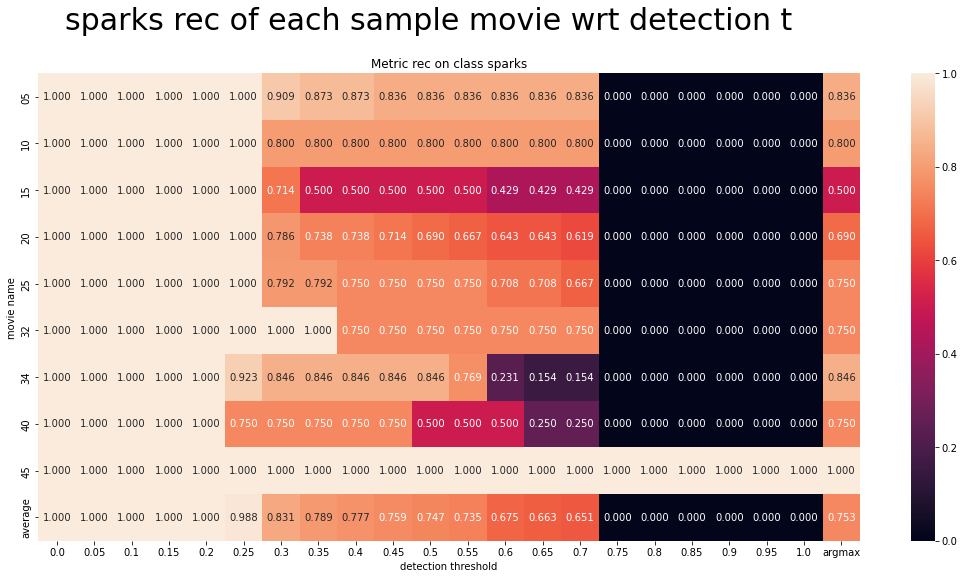

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 8), squeeze = False)
plt.subplots_adjust(hspace=0.1, wspace=0.01, top=0.85)
fig.suptitle(f"{event_type} {metric_name} of each sample movie wrt detection t", fontsize=30, y=1, x=0.4)

i=0
j=0

# loop through metrics, thresholds and axes
df_values = spark_peaks_df[(spark_peaks_df['Event type']==event_type) 
                         & (spark_peaks_df['Min r']==min_r) 
                         & (spark_peaks_df['Metric']==metric_name)]
# create pivot table, detection thresholds will be rows, min radius will be columns
piv = pd.pivot_table(df_values, values="Val",index=["Movie name"], columns=["Detection t"])

#plot pivot table as heatmap using seaborn
axs[i,j].set_title(f"Metric {metric_name} on class {event_type}")
sns.heatmap(piv, annot=True, fmt='.3f', vmin=0, vmax=1, ax=axs[i,j])#, square=True)
axs[i,j].set_ylabel("movie name")
axs[i,j].set_xlabel("detection threshold")

plt.setp(axs[i,j].yaxis.get_majorticklabels(), rotation=90) # rotate y labels
plt.tight_layout()

#ax.get_legend().remove()

plt.savefig(os.path.join(spark_peaks_res_dir,"MEETING_"+event_type+"_"+metric_name+"_heatmap.png"))

### Get movies that contain sparks
number of annotated pixels = tp + fn

In [31]:
min_r = '0'
detection_t = '0.5'
metrics_annot = 'tp_fn'

In [32]:
# movies that contain puffs
event_type = 'sparks'


df_values = spark_peaks_df[(spark_peaks_df['Event type']==event_type) 
                         & (spark_peaks_df['Min r']==min_r) 
                         & (spark_peaks_df['Detection t']==detection_t)
                         & (spark_peaks_df['Metric']==metrics_annot)
                        ]

# get list of movies that contains sparks
n_annot = df_values[(df_values['Metric']==metrics_annot)]['Val'].values
spark_movies = n_annot > 0
spark_movies_names = [movie_name for movie_name, present in zip(movie_names, spark_movies) if present and movie_name != 'average']
spark_movies_names

['05', '10', '15', '20', '25', '32', '34', '40']

### Compute average prec, rec and F1 score for movies that contain sparks

In [33]:
per_movie_spark_peaks_rows = []
for event_class in ys_classes:
    # load saved dict and get rows for dataframe
    dict_filename = os.path.join(spark_peaks_res_dir, event_class+"_results.json" )
    with open(dict_filename, 'r') as f:
        original_res = json.load(f) # movie_name x t x min_r x video_id x metrics
        for movie_name, t_res in original_res.items():
            if (event_class == 'sparks') and (movie_name in puff_movies_names):
                for t, min_r_res in t_res.items():
                    for min_r, val in min_r_res.items():
                        prec = val['tp']/(val['tp_fp']) if (val['tp_fp']) != 0 else 1.0
                        rec = val['tp']/(val['tp_fn']) if (val['tp_fn']) != 0 else 1.0
                        per_movie_spark_peaks_rows.append([event_class, movie_name, t, min_r, 'prec', prec])
                        per_movie_spark_peaks_rows.append([event_class, movie_name, t, min_r, 'rec', rec])
                        per_movie_spark_peaks_rows.append([event_class, movie_name, t, min_r, 'f1_score', compute_f_score(prec, rec, 1)])
                        
            per_movie_spark_peaks_df = pd.DataFrame(per_movie_spark_peaks_rows, columns =['Event type', 'Movie name', 'Detection t', 'Min r', 'Metric', 'Val'])

In [34]:
event_class = 'sparks'
metric = 'f1_score'
min_radius = per_pixel_df['Min r'].unique()
thresholds = per_pixel_df['Detection t'].unique()

In [35]:
average_spark_peaks_rows = []

for event_class in ys_classes:
    for metric in metrics:
        df_values = per_movie_spark_peaks_df[(per_movie_spark_peaks_df['Event type']==event_class)
                                         & (per_movie_spark_peaks_df['Metric']==metric)]

        for min_r in min_radius:
            for t in thresholds:
                avg = df_values[(df_values['Min r']==min_r)
                                & (df_values['Detection t']==t)
                               ]['Val'].mean()
                average_spark_peaks_rows.append([event_class, t, min_r, metric, avg])

average_spark_peaks_df = pd.DataFrame(average_spark_peaks_rows, columns =['Event type', 'Detection t', 'Min r', 'Metric', 'Val'])

In [36]:
average_spark_peaks_df.to_csv(os.path.join(spark_peaks_res_dir,"POSTER_average_metrics_sparks.csv"))

In [34]:
average_spark_peaks_df[(average_spark_peaks_df['Min r']==min_r) 
                       & (average_spark_peaks_df['Metric'].isin(['prec','rec']))
                       & ~(average_spark_peaks_df['Detection t']=='argmax')
                      ]

,Event type,Detection t,Min r,Metric,Val
66,sparks,0.0,6,prec,NaN
67,sparks,0.05,6,prec,NaN
68,sparks,0.1,6,prec,NaN
69,sparks,0.15,6,prec,NaN
70,sparks,0.2,6,prec,NaN
71,sparks,0.25,6,prec,NaN
72,sparks,0.3,6,prec,NaN
73,sparks,0.35,6,prec,NaN
74,sparks,0.4,6,prec,NaN
75,sparks,0.45,6,prec,NaN


### Plot results

Average prec value for class sparks using argmax preds is 0.286103285210798
Average rec value for class sparks using argmax preds is 0.7403742091242091
Average f1_score value for class sparks using argmax preds is 0.3943836354445309


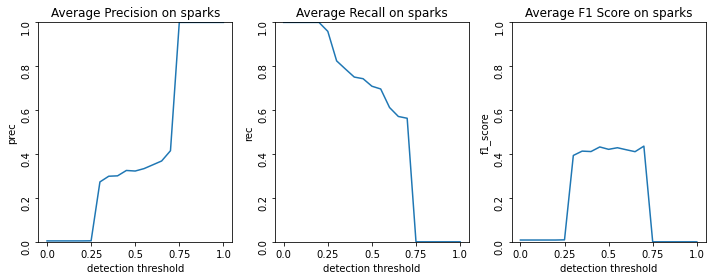

In [35]:
# create plot for all classes and all metrics
#fig, axs = plt.subplots(ncols=len(metrics)+1, nrows=1, figsize=(10, 4), squeeze = False)
fig, axs = plt.subplots(ncols=len(metrics), nrows=1, figsize=(10, 4), squeeze = False)
plt.subplots_adjust(hspace=0.1, wspace=0.01, top=0.85)
#fig.suptitle(f"Per pixel average metrics with respect to threshold", fontsize=20, y=1)

min_r = '0'
metric_full_name = {'prec': "Precision",
                    'rec': "Recall",
                    'f1_score': "F1 Score"
                   }
                        
# loop through metrics, thresholds and axes
for j, metric_name in enumerate(metrics):
    for i, class_event in enumerate(ys_classes):
        df_values = average_spark_peaks_df[(average_spark_peaks_df['Event type']==class_event) 
                                           & (average_spark_peaks_df['Metric']==metric_name)  
                                           & (average_spark_peaks_df['Min r']==min_r) 
                                           & ~(average_spark_peaks_df['Detection t']=='argmax')
                                          ]

        argmax_val = average_spark_peaks_df[(average_spark_peaks_df['Event type']==class_event) 
                                           & (average_spark_peaks_df['Metric']==metric_name)  
                                           & (average_spark_peaks_df['Min r']==min_r) 
                                           & (average_spark_peaks_df['Detection t']=='argmax')
                                          ]['Val'].values[0]

        print(f"Average {metric_name} value for class {class_event} using argmax preds is {argmax_val}")
    # create pivot table, detection thresholds will be rows, min radius will be columns
        piv = pd.pivot_table(df_values, values="Val",columns=["Metric"], index=["Detection t"])
        
        # plot pivot table
        axs[i,j].set_title(f"Average {metric_full_name[metric_name]} on {class_event}")
        piv.plot(ax=axs[i,j])
        axs[i,j].set_ylabel(metric_name)
        axs[i,j].set_ylim(0,1)
        axs[i,j].set_xlabel("detection threshold")
        
        plt.setp(axs[i,j].yaxis.get_majorticklabels(), rotation=90) # rotate y labels
        plt.tight_layout()
        
        axs[i,j].get_legend().remove()

'''prec_list = average_spark_peaks_df[(average_spark_peaks_df['Event type']==class_event) 
                                           & (average_spark_peaks_df['Metric']=='prec')  
                                           & (average_spark_peaks_df['Min r']==min_r) 
                                           & ~(average_spark_peaks_df['Detection t']=='argmax')
                                          ]['Val'].values

rec_list = average_spark_peaks_df[(average_spark_peaks_df['Event type']==class_event) 
                                           & (average_spark_peaks_df['Metric']=='rec')  
                                           & (average_spark_peaks_df['Min r']==min_r) 
                                           & ~(average_spark_peaks_df['Detection t']=='argmax')
                                          ]['Val'].values



axs[0,3].set_title(f"Average precision-recall curve on sparks")
axs[0,3].plot(rec_list, prec_list, marker='.', linestyle='')
axs[0,3].set_ylabel('precision')
axs[0,3].set_ylim(0,1)
axs[0,3].set_xlabel('recall')

plt.setp(axs[0,3].yaxis.get_majorticklabels(), rotation=90) # rotate y labels'''
plt.tight_layout()        
plt.savefig(os.path.join(spark_peaks_res_dir,"POSTER_average_metrics_sparks.png"))